In [1]:
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
fund = pd.read_excel("data/Taylor rule fundamentals data.xls", sheet_name="original",
                     header=2, index_col=0, na_values=[".", "     ."])

In [3]:
# Drop empty columns
fund = fund.dropna(axis=1, how="all")

In [4]:
# Convert index to datetime with monthly frequency
fund.index = pd.to_datetime(fund.index, format="%YM%m")
fund.index = pd.DatetimeIndex(fund.index, freq="MS")

Currency pairs to forecast: GPB:USD (Great Britsh Pound:US Dollar), CAD:USD (Canadian Dollar:US Dollar).

Relevant Columns:
- (O.2): USD:CAD X-Rate
- (O.4): GBP:USD X-Rate
- (O.28): Federal Funds Rate, United States
- (O.29): Money Market Rate, Canada
- (O.31): Money Market Rate, U.K.
- (O.41): Industrial Production, United States
- (O.43): Industrial Production, Canada
- (O.45): Industrial Production, U.K.
- (O.55): CPI, United States
- (O.57): CPI, Canada
- (O.59): CPI, U.K.

In [5]:
# Format column names
fund.columns = fund.columns.str.strip("(O.)")

In [6]:
# Subset with relevant columns
fund = fund[["2", "4",
             "28", "29", "31",
             "41", "43", "45",
             "55", "57", "59"]]

In [7]:
# Rename columns
fund = fund.rename(columns={"2": "USDCAD", "4": "GBPUSD",
                            "28": "i_US", "29": "i_CA", "31": "i_UK",
                            "41": "Y_US", "43": "Y_CA", "45": "Y_UK",
                            "55": "CPI_US", "57": "CPI_CA", "59": "CPI_UK"})

In [8]:
# Put x-rates in log USD terms
fund["USDCAD"] = np.log(1/fund["USDCAD"])
fund = fund.rename(columns={"USDCAD": "CADUSD"})
fund["GBPUSD"] = np.log(fund["GBPUSD"])

In [9]:
# Get 1 period ahead change in x-rate
fund["CADUSD_ahead"] = fund["CADUSD"].shift(-1)
fund["GBPUSD_ahead"] = fund["GBPUSD"].shift(-1)
fund["CADUSD_ahead_change"] = fund["CADUSD"].shift(-1) - fund["CADUSD"]
fund["GBPUSD_ahead_change"] = fund["GBPUSD"].shift(-1) - fund["GBPUSD"]

In [10]:
# Calculate inflation
fund["infl_US"] = np.log(fund["CPI_US"]/fund["CPI_US"].shift(12))
fund["infl_CA"] = np.log(fund["CPI_CA"]/fund["CPI_CA"].shift(12))
fund["infl_UK"] = np.log(fund["CPI_UK"]/fund["CPI_UK"].shift(12))

In [11]:
# Create time index
fund["t"] = [t for t in range(len(fund))]

In [12]:
# Potential output using linear time trend
def recursive_potential(column):
    potential = pd.Series(index=fund.index, dtype="float64")
    
    for t in fund.index:
        # Regress output on time index using all available data before t
        lin_trend = ols(column + "~ t", fund[:t]).fit()
        
        # Estimate potential using fitted values
        potential[t] = lin_trend.predict()[-1]
        
    return potential

In [13]:
# Estimate potential output using linear time trend
fund["Y_bar_US"] = recursive_potential("Y_US")
fund["Y_bar_CA"] = recursive_potential("Y_CA")
fund["Y_bar_UK"] = recursive_potential("Y_UK")

In [14]:
# Calculate output gap
fund["y_US"] = np.log(fund["Y_US"]/fund["Y_bar_US"])
fund["y_CA"] = np.log(fund["Y_CA"]/fund["Y_bar_CA"])
fund["y_UK"] = np.log(fund["Y_UK"]/fund["Y_bar_UK"])

In [15]:
# Get lagged nominal interest rates
fund["i_lag_US"] = fund["i_US"].shift(1)
fund["i_lag_CA"] = fund["i_CA"].shift(1)
fund["i_lag_UK"] = fund["i_UK"].shift(1)

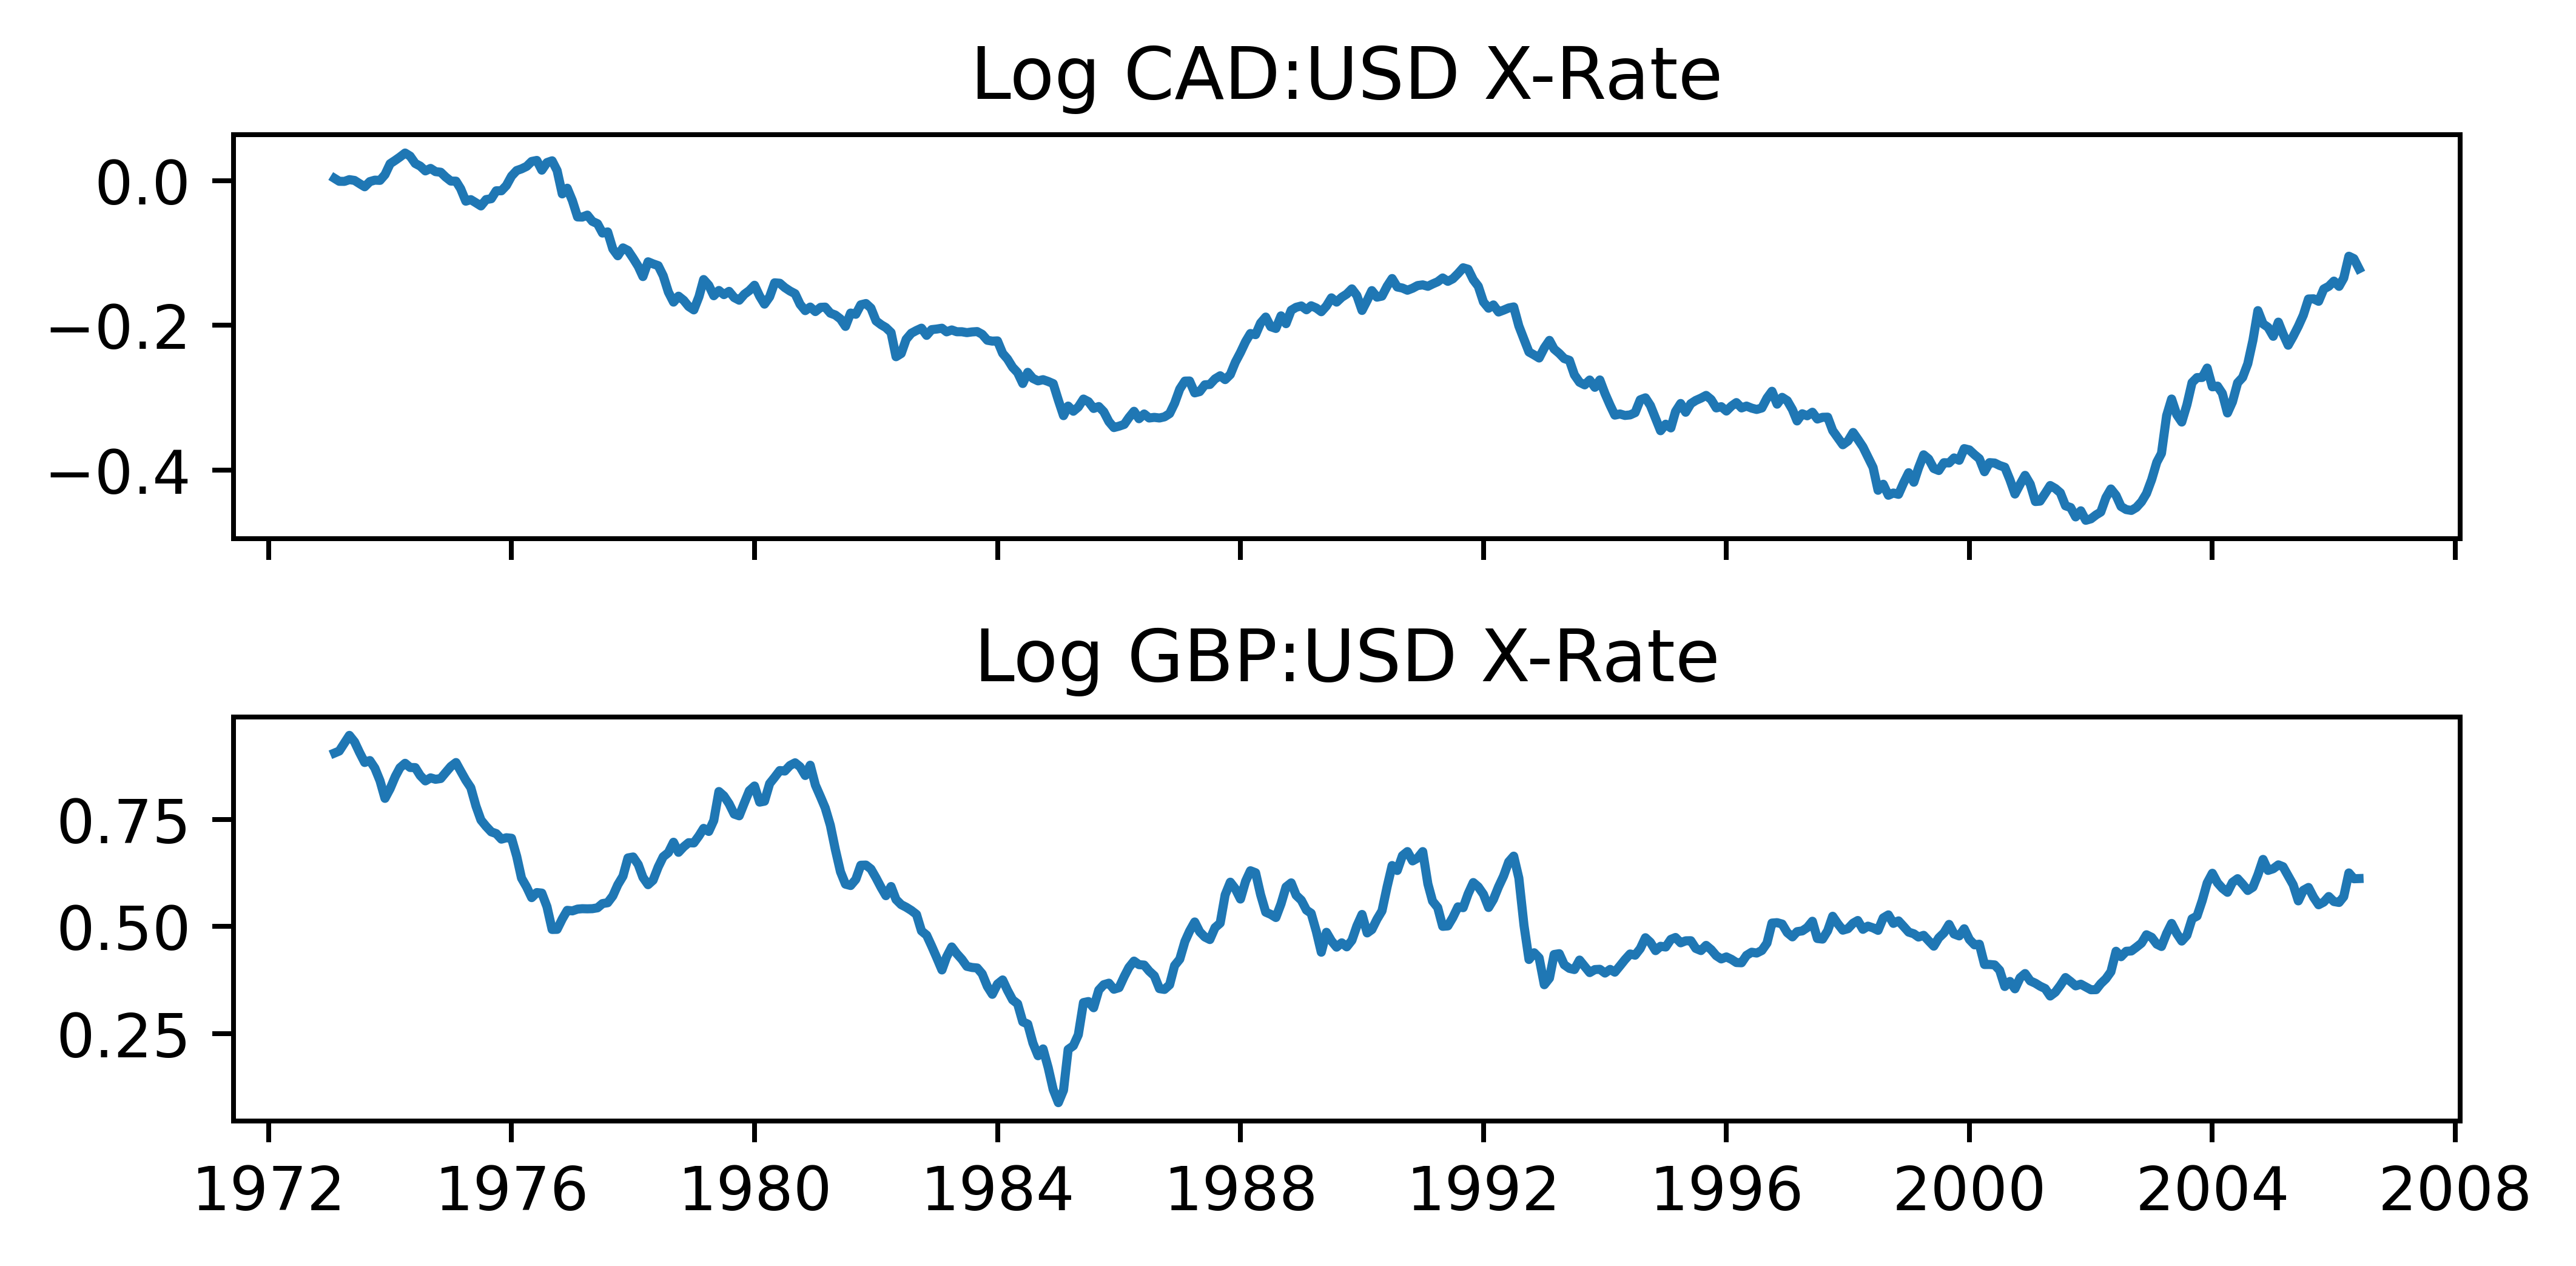

In [16]:
fig, axes = plt.subplots(2, 1, sharex=True,
                         figsize=(6, 3), dpi=720)
axes[0].plot(fund["CADUSD_ahead"])
axes[0].set_title("Log CAD:USD X-Rate")
axes[1].plot(fund["GBPUSD_ahead"])
axes[1].set_title("Log GBP:USD X-Rate")
plt.tight_layout()
plt.show()

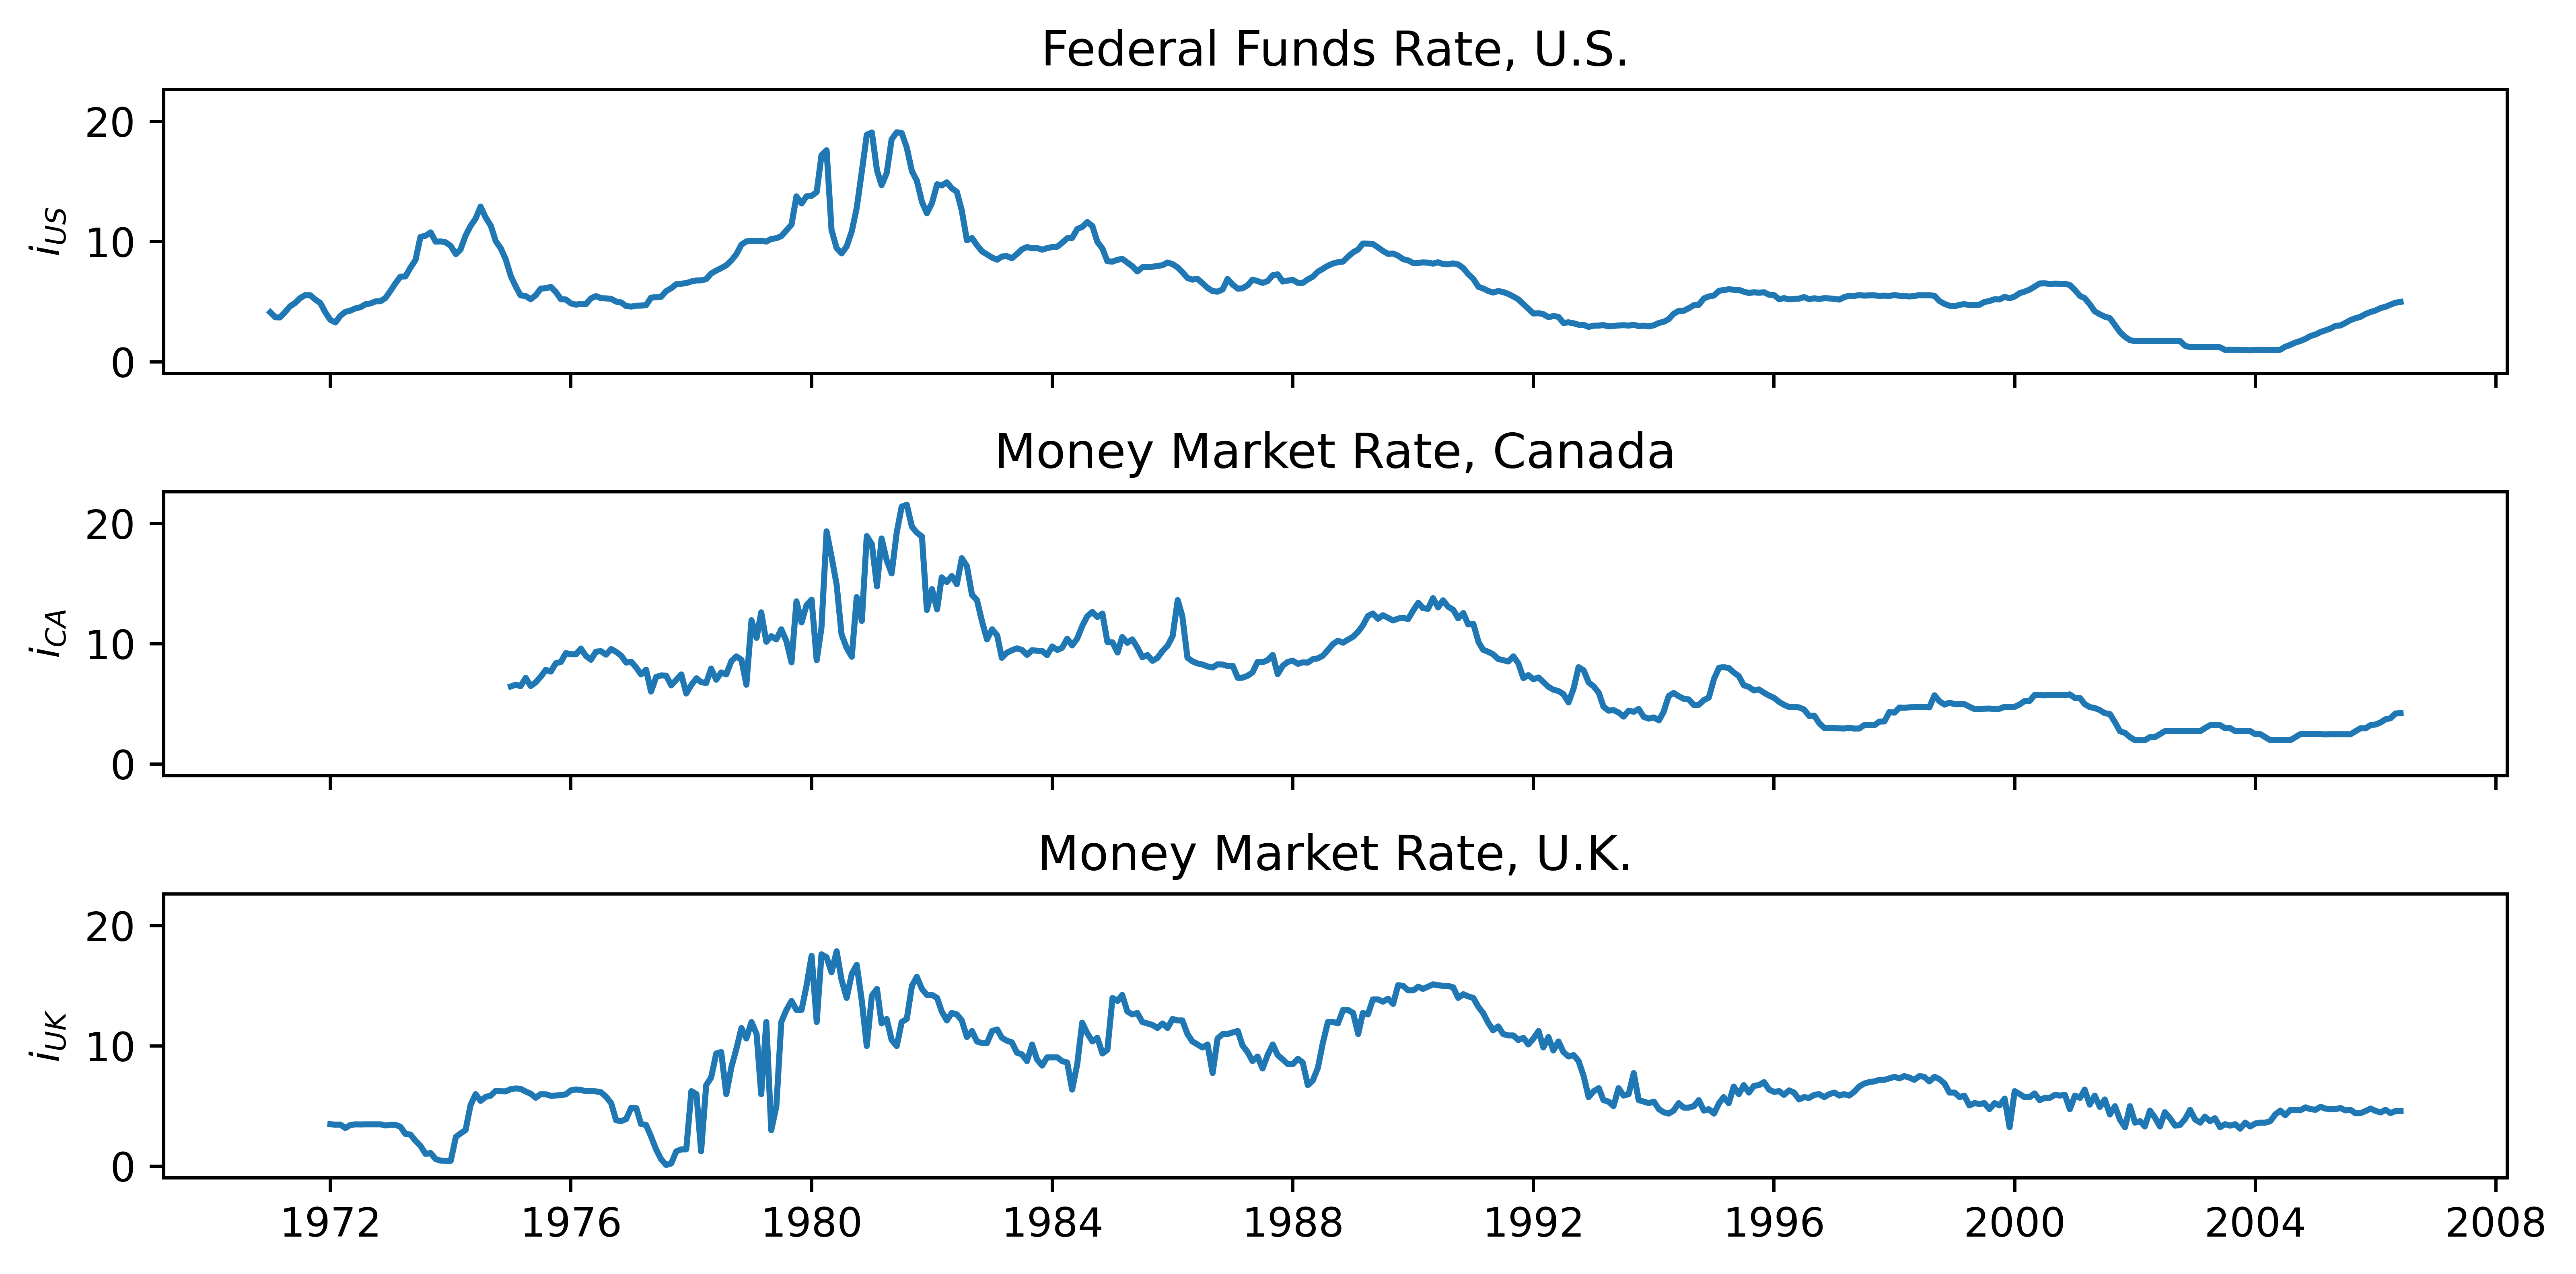

In [17]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True,
                         figsize=(9, 4.5), dpi=720)
axes[0].plot(fund["i_US"])
axes[0].set_ylabel("$i_{US}$")
axes[0].set_title("Federal Funds Rate, U.S.")
axes[1].plot(fund["i_CA"])
axes[1].set_ylabel("$i_{CA}$")
axes[1].set_title("Money Market Rate, Canada")
axes[2].plot(fund["i_UK"])
axes[2].set_ylabel("$i_{UK}$")
axes[2].set_title("Money Market Rate, U.K.")
plt.tight_layout()
plt.show()

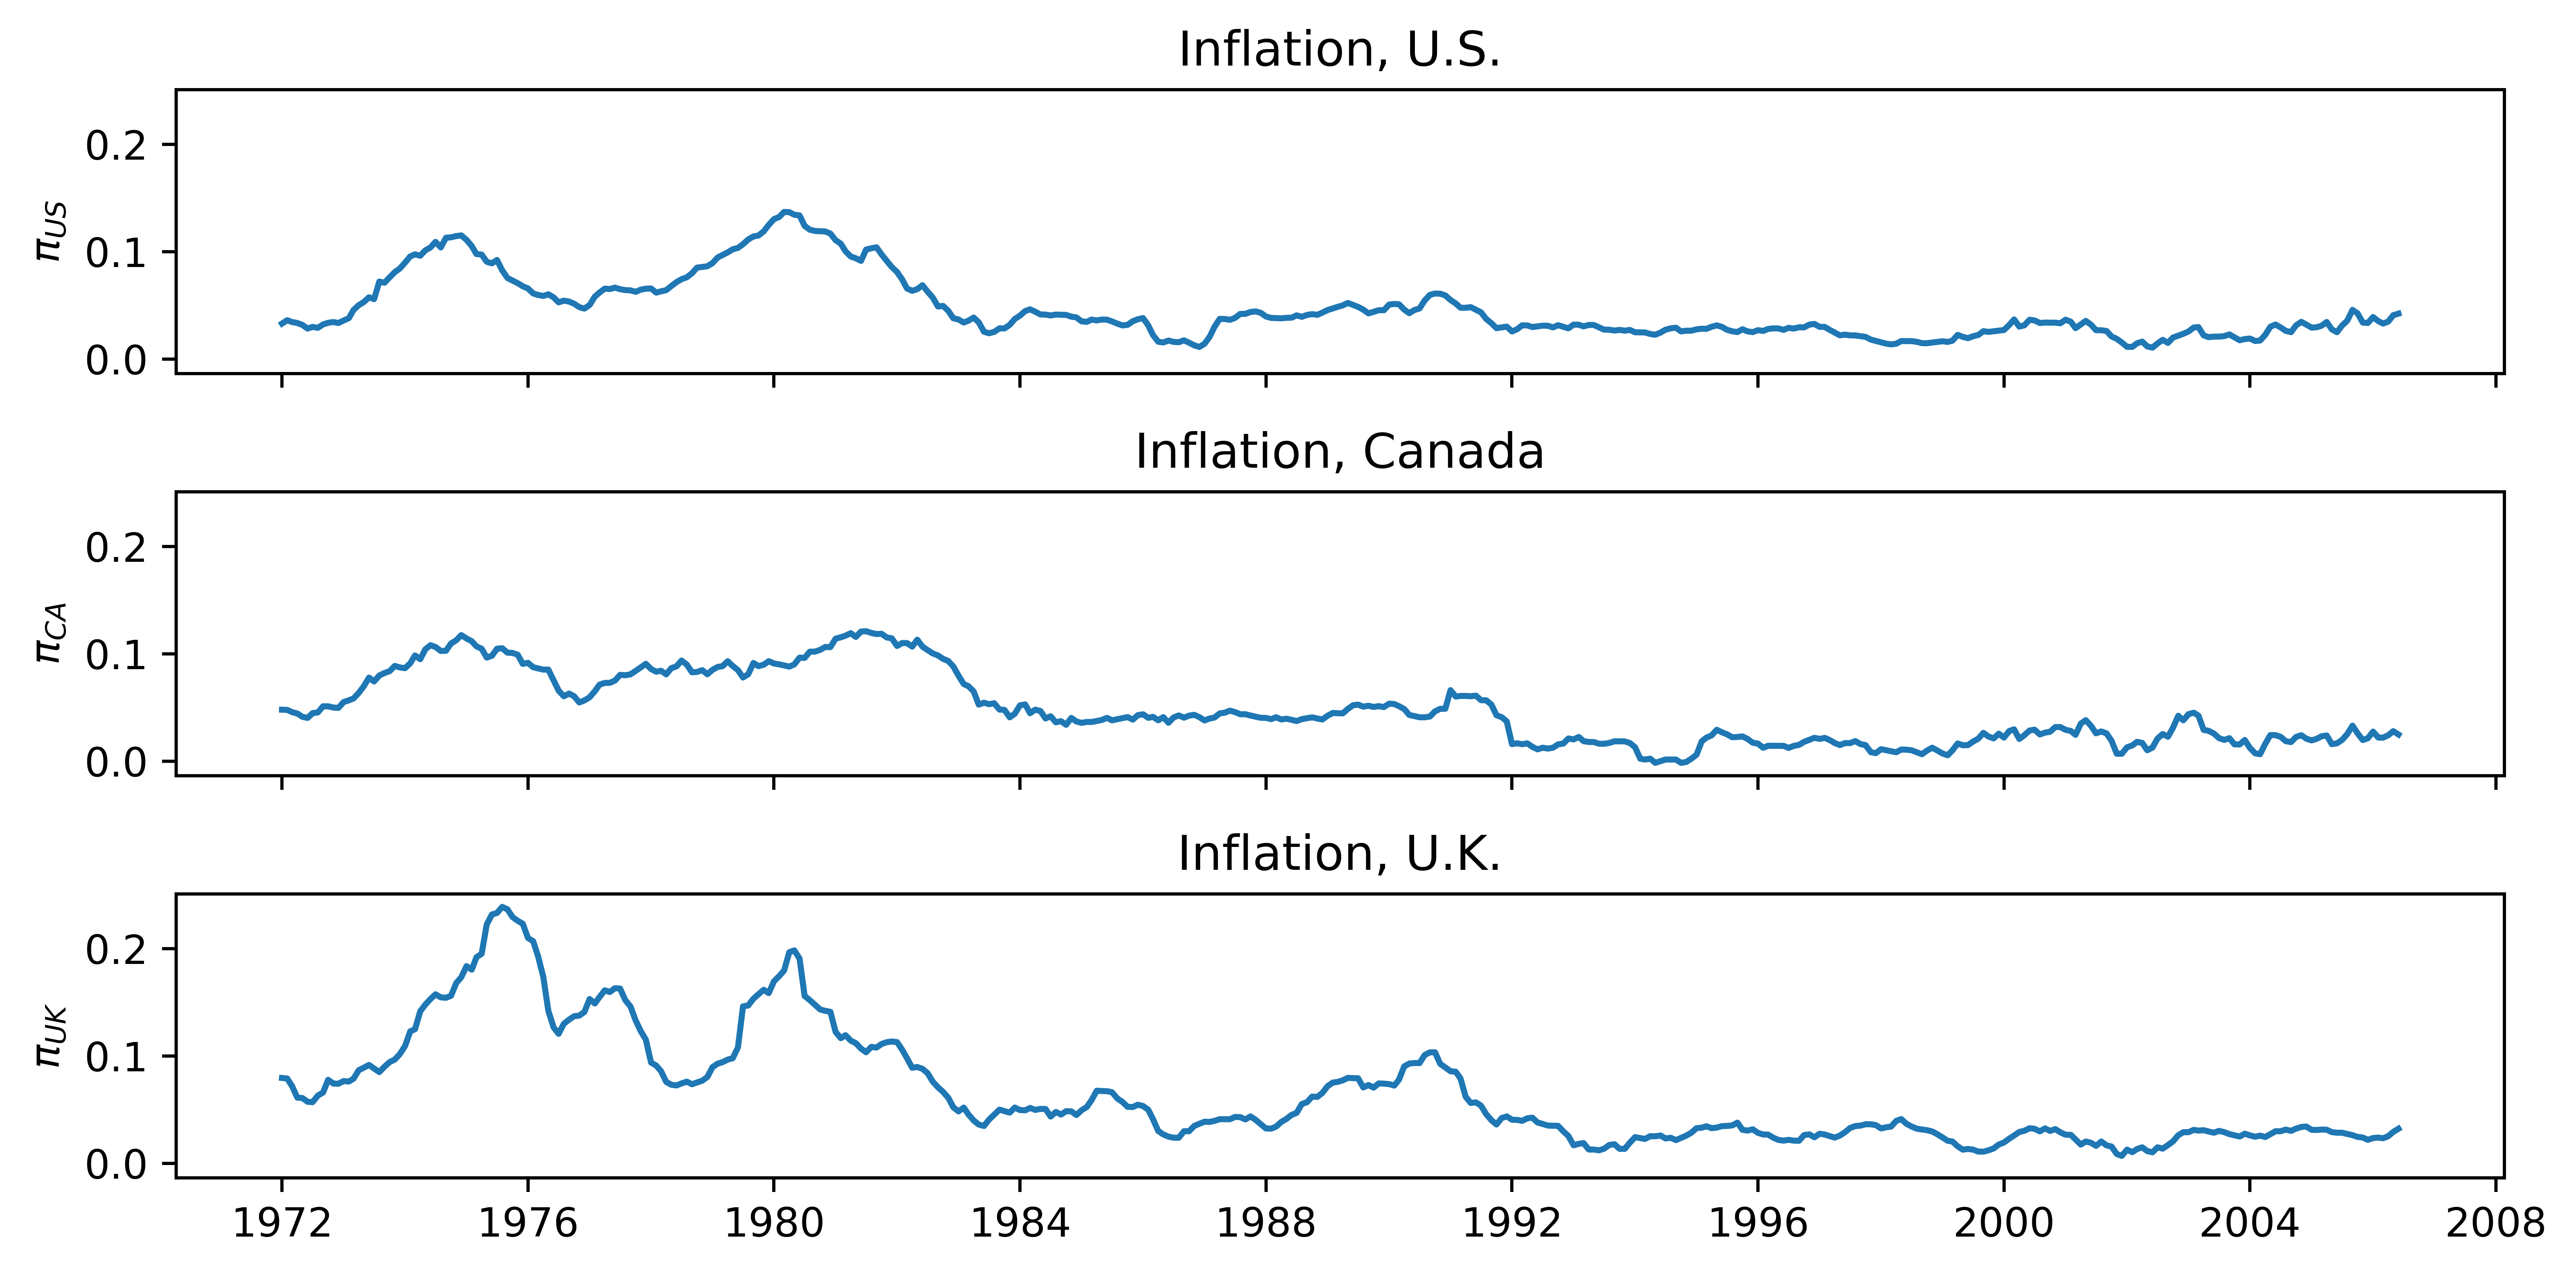

In [18]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True,
                         figsize=(9, 4.5), dpi=720)
axes[0].plot(fund["infl_US"])
axes[0].set_ylabel("$\pi_{US}$")
axes[0].set_title("Inflation, U.S.")
axes[1].plot(fund["infl_CA"])
axes[1].set_ylabel("$\pi_{CA}$")
axes[1].set_title("Inflation, Canada")
axes[2].plot(fund["infl_UK"])
axes[2].set_ylabel("$\pi_{UK}$")
axes[2].set_title("Inflation, U.K.")
plt.tight_layout()
plt.show()

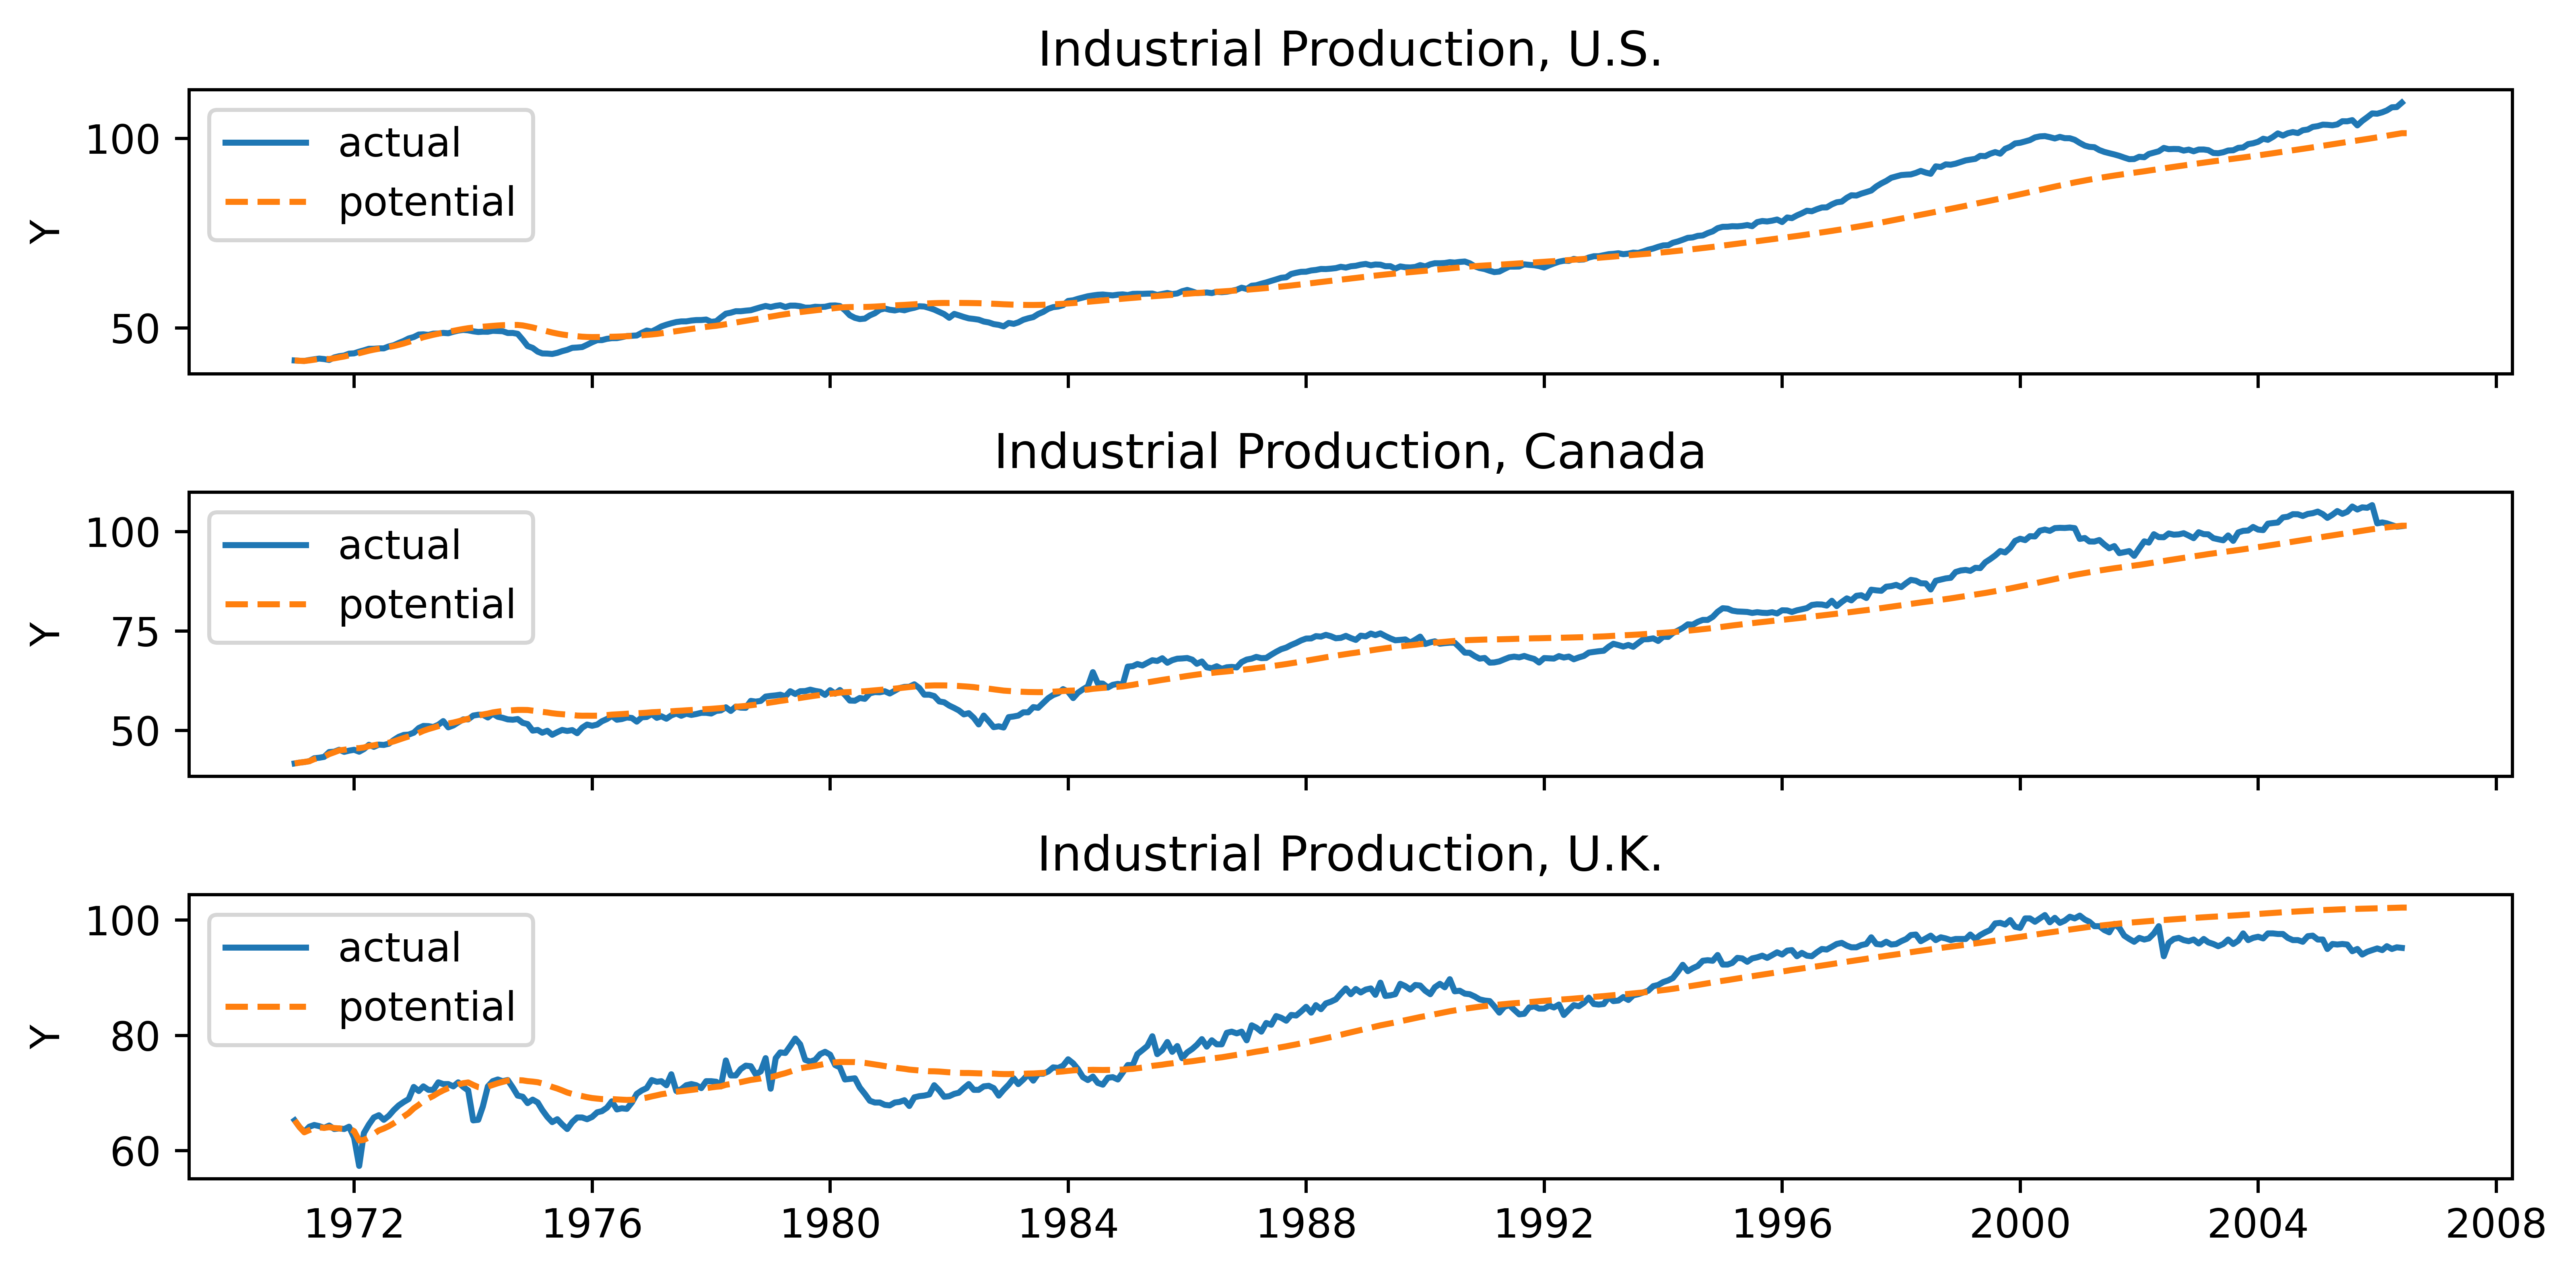

In [19]:
fig, axes = plt.subplots(3, 1, sharex=True,
                         figsize=(9, 4.5), dpi=720)
axes[0].plot(fund["Y_US"], label="actual")
axes[0].plot(fund["Y_bar_US"], linestyle="--", label="potential")
axes[0].set_ylabel("Y")
axes[0].set_title("Industrial Production, U.S.")
axes[0].legend()
axes[1].plot(fund["Y_CA"], label="actual")
axes[1].plot(fund["Y_bar_CA"], linestyle="--", label="potential")
axes[1].set_ylabel("Y")
axes[1].set_title("Industrial Production, Canada")
axes[1].legend()
axes[2].plot(fund["Y_UK"], label="actual")
axes[2].plot(fund["Y_bar_UK"], linestyle="--", label="potential")
axes[2].set_ylabel("Y")
axes[2].set_title("Industrial Production, U.K.")
axes[2].legend()
plt.tight_layout()
plt.show()

In [20]:
# Rolling forecasts
def rolling_forecast(xrate, country):
    window = pd.DataFrame({"xrate_change": fund[xrate+"_ahead_change"],
                           "infl": fund["infl_US"],
                           "infl_tilde": fund["infl_"+country],
                           "y": fund["y_US"],
                           "y_tilde": fund["y_"+country],
                           "i_lag": fund["i_lag_US"],
                           "i_lag_tilde": fund["i_lag_"+country]}).dropna()
    
    forecasts = pd.Series(index=window.index, dtype="float64")
    
    for t in range(120, len(window)):
        # Fit symmetric Taylor Rule model with smoothing, heterogenous coefficients, constant term
        mod = ols("xrate_change ~ infl + infl_tilde + y + y_tilde + i_lag + i_lag_tilde",
                  window[t-120:t])
        res = mod.fit()

        
        # One-step ahead forecast
        forecasts[t] = res.predict(window[t:t+1])
        
    
    return forecasts

In [22]:
# Make forecasts of x-rate change
fund["CADUSD_change_taylorforecast"] = rolling_forecast("CADUSD", "CA")
fund["GBPUSD_change_taylorforecast"] = rolling_forecast("GBPUSD", "UK")

In [23]:
# Recover forecasted x-rate
fund["CADUSD_taylorforecast"] = fund["CADUSD"] + fund["CADUSD_change_taylorforecast"]
fund["GBPUSD_taylorforecast"] = fund["GBPUSD"] + fund["GBPUSD_change_taylorforecast"]

In [24]:
# Random walk forecasts
fund["CADUSD_rwforecast"] = fund["CADUSD"]
fund["GBPUSD_rwforecast"] = fund["GBPUSD"]

In [25]:
# Save forecasts in new frames
cadusd = fund[["CADUSD_ahead", "CADUSD_rwforecast",
               "CADUSD_taylorforecast", "CADUSD_change_taylorforecast"]].dropna()
gbpusd = fund[["GBPUSD_ahead", "GBPUSD_rwforecast",
               "GBPUSD_taylorforecast", "GBPUSD_change_taylorforecast"]].dropna()

In [26]:
# MSPE for CADUSD forecasts
CADUSD_MSPE_rw = np.mean((cadusd["CADUSD_ahead"] - cadusd["CADUSD_rwforecast"])**2)
print("MSEPE_rw =", CADUSD_MSPE_rw)
CADUSD_MSPE_taylor = np.mean((cadusd["CADUSD_ahead"] - cadusd["CADUSD_taylorforecast"])**2)
print("MSPE_taylor =", CADUSD_MSPE_taylor)

MSEPE_rw = 0.00015919533141950376
MSPE_taylor = 0.00016114239924600778


In [27]:
# Diebold-Mariano-West Test for CADUSD forecasts
P = len(cadusd)
V_hat = np.mean(((cadusd["CADUSD_ahead"]-cadusd["CADUSD_rwforecast"])**2 - (cadusd["CADUSD_ahead"]-cadusd["CADUSD_taylorforecast"])**2 - (CADUSD_MSPE_rw-CADUSD_MSPE_taylor))**2)
DMW = (CADUSD_MSPE_rw-CADUSD_MSPE_taylor)/(np.sqrt(V_hat/P))
print("DMW =", DMW)

# Print p-value
# sf = Survival function (also defined as 1 - cdf, but sf is sometimes more accurate)
print("p =", norm.sf(DMW))

DMW = -0.2477060990945812
p = 0.597819093739227


In [28]:
# Clark-West Test for CADUSD forecasts
CW = DMW + 1/(np.sqrt(V_hat/P)) * np.mean(cadusd["CADUSD_change_taylorforecast"]**2)
print("CW =", CW)

# Print p-value
print("p =", norm.sf(CW))

CW = 2.438565284155798
p = 0.007372847468782419


In [29]:
# MSPE for DMW test GBPUSD forecasts
GBPUSD_MSPE_rw = np.mean((gbpusd["GBPUSD_rwforecast"] - gbpusd["GBPUSD_ahead"])**2)
print("MSEPE_rw =", GBPUSD_MSPE_rw)
GBPUSD_MSPE_taylor = np.mean((gbpusd["GBPUSD_taylorforecast"] - gbpusd["GBPUSD_ahead"])**2)
print("MSPE_taylor =", GBPUSD_MSPE_taylor)

MSEPE_rw = 0.0006244945830137344
MSPE_taylor = 0.000689252938847717


In [30]:
# Diebold-Mariano-West Test for GBPUSD forecasts
P = len(gbpusd)
V_hat = np.mean(((gbpusd["GBPUSD_ahead"]-gbpusd["GBPUSD_rwforecast"])**2-(gbpusd["GBPUSD_ahead"]-gbpusd["GBPUSD_taylorforecast"])**2-(GBPUSD_MSPE_rw-GBPUSD_MSPE_taylor))**2)
DMW = (GBPUSD_MSPE_rw-GBPUSD_MSPE_taylor)/(np.sqrt(V_hat/P))
print("DMW =", DMW)

# p-value
print("p =", norm.sf(DMW))

DMW = -1.7352481674416267
p = 0.9586515708988825


In [31]:
# Clark-West Test for GBPUSD forecasts
CW = DMW + 1/(np.sqrt(V_hat/P)) * np.mean(gbpusd["GBPUSD_change_taylorforecast"]**2)
print("CW =", CW)

# p-value
print("p =", norm.sf(CW))

CW = 1.8981172003445783
p = 0.028840322413576057


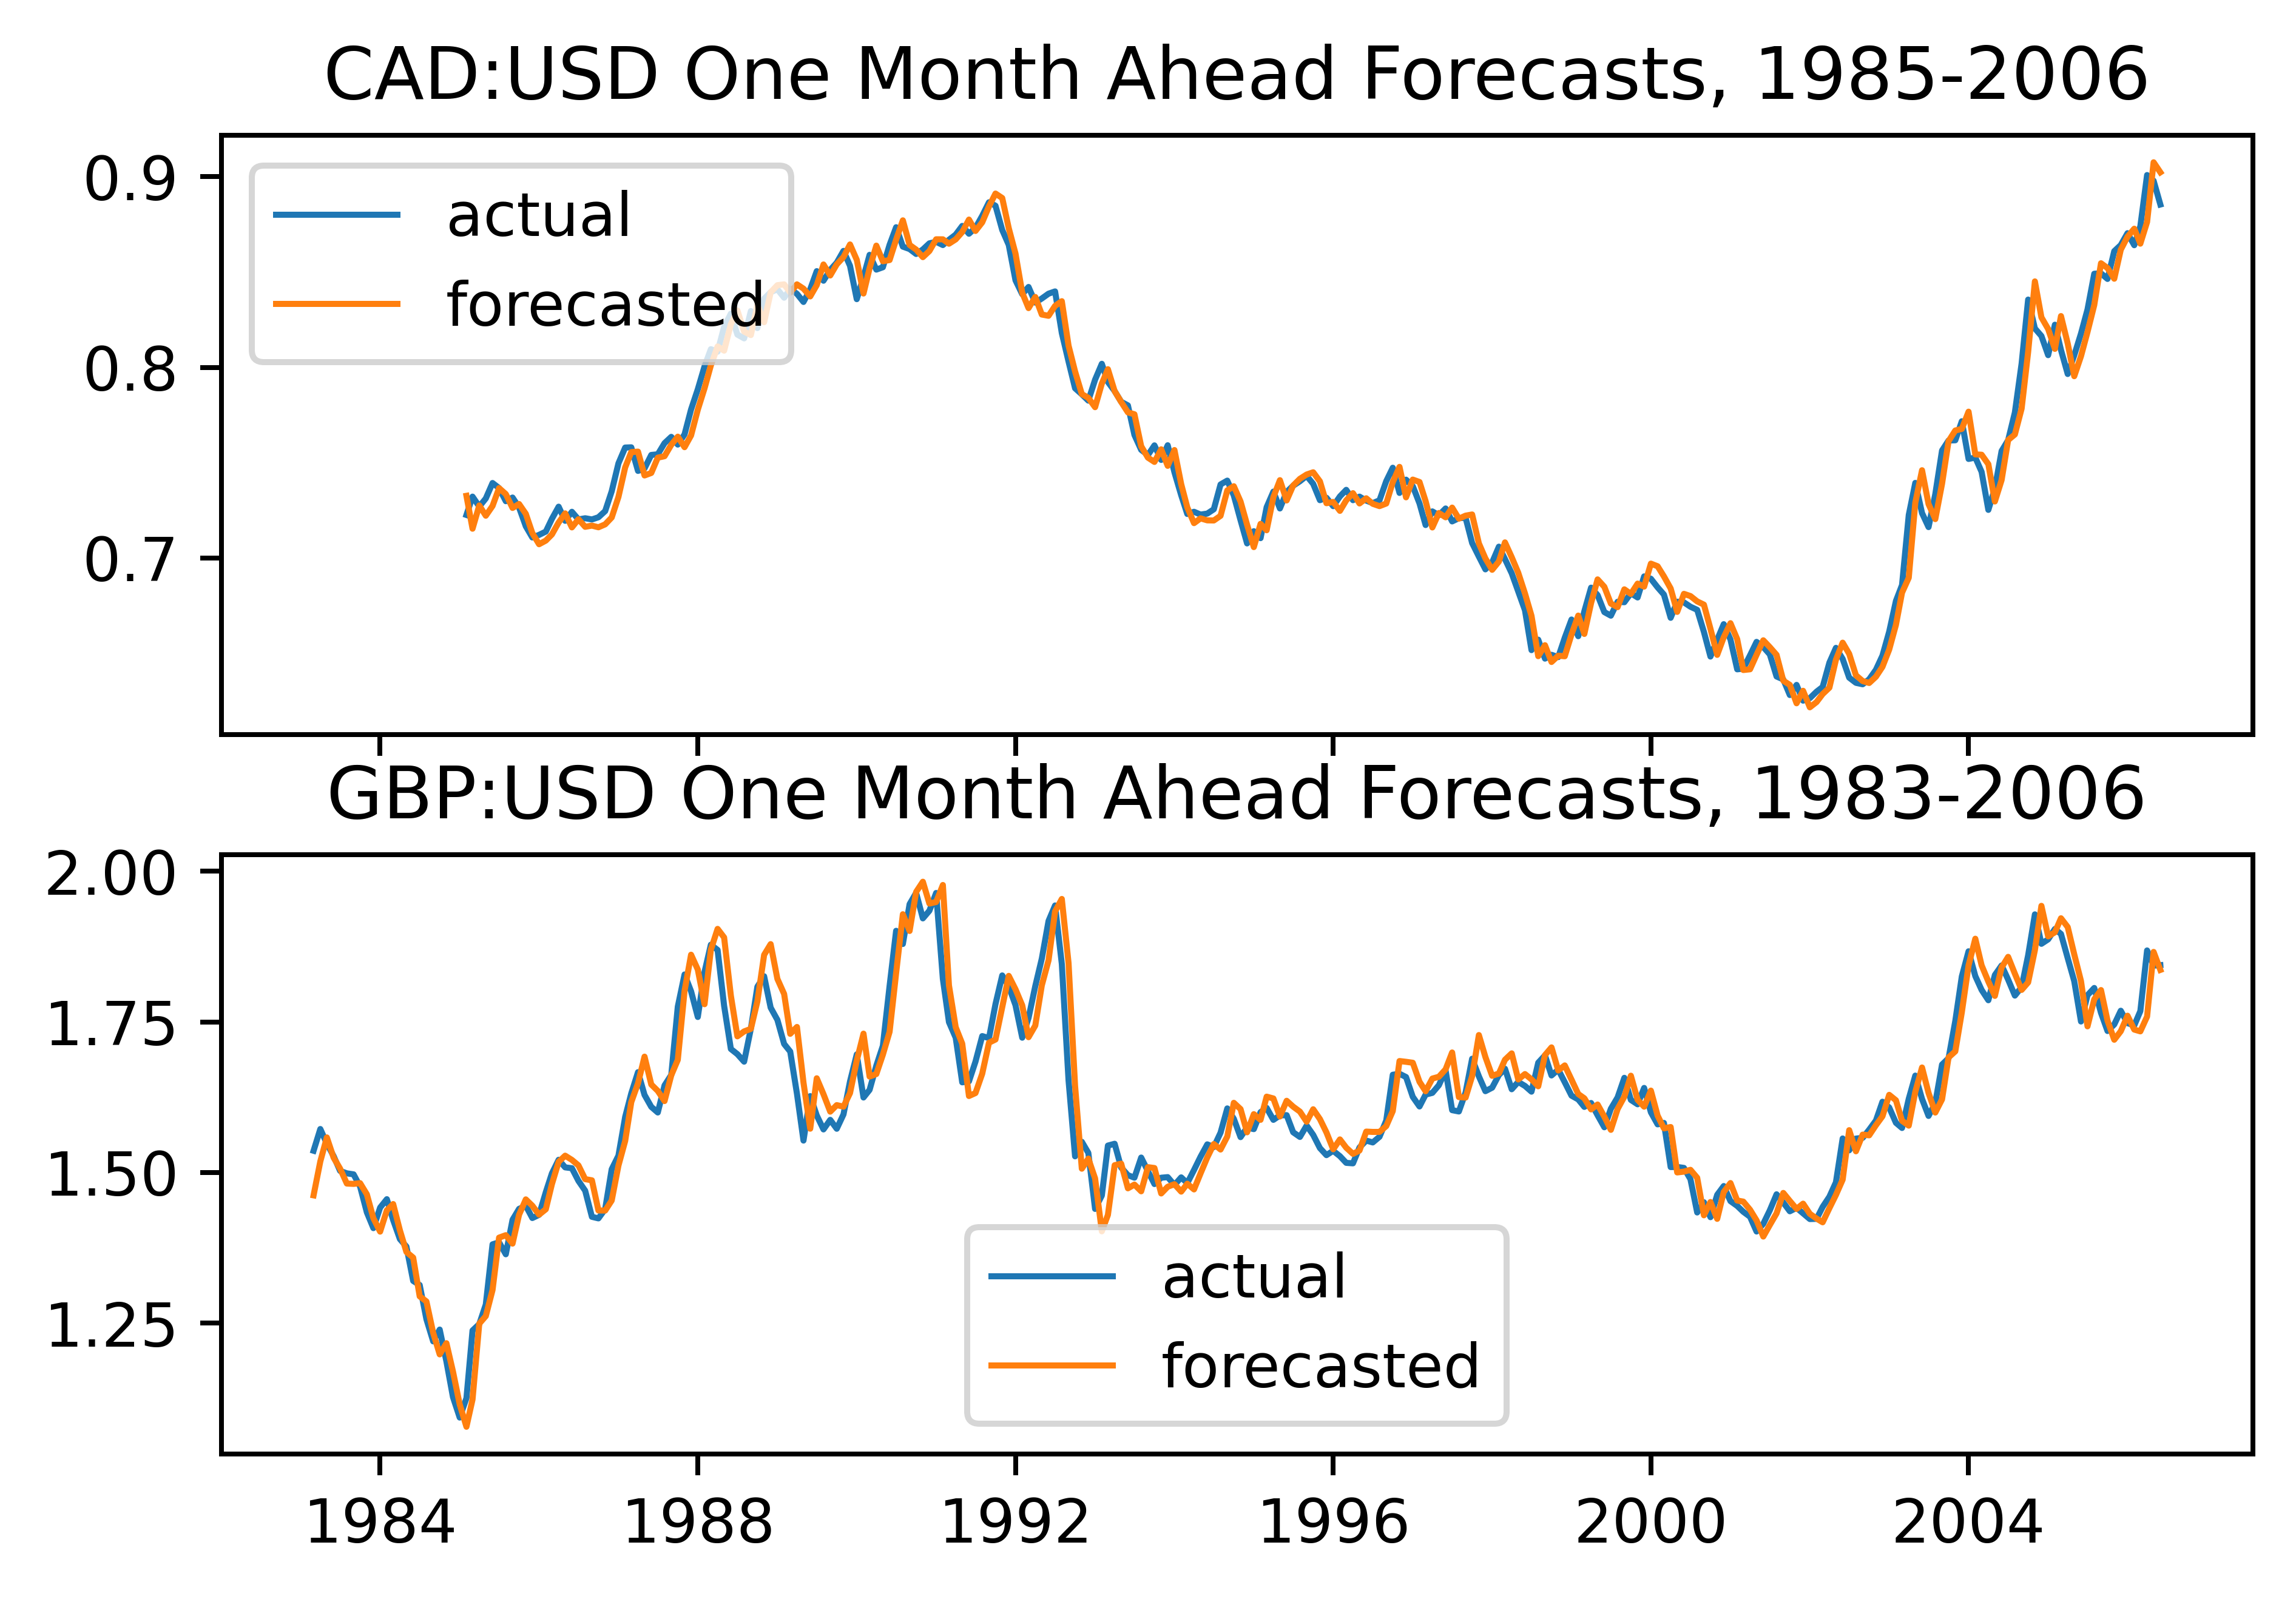

In [34]:
# Plot forecasts
fig, axes = plt.subplots(2, 1, figsize=(6, 4), sharex=True, dpi=720)
axes[0].plot(np.exp(cadusd["CADUSD_ahead"]), linewidth=1, label="actual")
axes[0].plot(np.exp(cadusd["CADUSD_taylorforecast"]), linewidth=1, label="forecasted")
axes[0].set_title("CAD:USD One Month Ahead Forecasts, 1985-2006")
axes[0].legend()
axes[1].plot(np.exp(gbpusd["GBPUSD_ahead"]), linewidth=1, label="actual")
axes[1].plot(np.exp(gbpusd["GBPUSD_taylorforecast"]), linewidth=1, label="forecasted")
axes[1].set_title("GBP:USD One Month Ahead Forecasts, 1983-2006")
axes[1].legend()
plt.savefig("forecasts.png")
plt.show()